# <font  color = "#0093AF">Propagators and Sequences</font>

Propagators are responsible for moving the density matrix, $\hat{\rho}(t)$ forward in time in magnetic resonance simulations. For a constant Liouvillian, the propagator, $\hat{\hat{U}}(t,t+\Delta t)$ is given by

$$
\begin{equation}
\hat{\hat{U}}(t,t+\Delta t)=\exp(\hat{\hat{L}}(t)\Delta t)
\end{equation}
$$

such that

$$
\begin{equation}
\hat{\rho}(t+\Delta t)=\hat{\hat{U}}(t,t+\Delta t)\hat{\rho}(t)
\end{equation}
$$

Of course, the Liouvillian is often not constant, either due to rotor spinning or a pulse sequence. In this case, the propagator is constructed as a product of piecewise constant propagators.

$$
\begin{equation}
U(t_0,t_n)=U(t_{n-1},t_{n})*U(t_{n-2},t_{n-1})*...*U(t_1,t_2)*U(t_0,t_1)
\end{equation}
$$

SLEEPY handles the construction of the propagator for a time-dependent Liouvillian from propagators generated from piecewise-constant Liouvillians internally. Here, we start without pulses, where time-dependence arises only from rotor spinning.

## Setup

In [1]:
# SETUP SLEEPY
import os
os.chdir('../../..')

In [2]:
import SLEEPY as sl
import numpy as np

## Build the system

In [3]:
ex=sl.ExpSys(v0H=600,Nucs=['1H','13C'],vr=60000) 
ex.set_inter('dipole',i0=0,i1=1,delta=44000).set_inter('CSA',i=1,delta=100,eta=1).\
    set_inter('CS',i=0,ppm=10) #Add a dipole, CSA to 13C, and CS to 1H

ex1=ex.copy() #Copy the above
ex1.set_inter('dipole',i0=0,i1=1,delta=44000,euler=[0,30*np.pi/180,0])

L=sl.Liouvillian(ex,ex1,kex=sl.Tools.twoSite_kex(1e-5)) #Here, we produce the exchange matrix with twoSite_kex

## Propagators without pulses

We first generate the default propagator from the Liouvillian. These propagators do not have contributions from applied RF-fields.

In [4]:
U=L.U()

`U` has a few key features: it has a starting time relative to the rotor period (`t0`), a length (`Dt`), and a final time (`tf`), calculated from `t0` and `Dt`. If unspecified when creating the propagator, the length is one rotor period (`L.taur`), since this helps make computational speed faster. Defining `Dt` will override this length. If spinning is not included, then `Dt` must be specified since the rotor period is no longer defined (note that even if spinning is specified in `ex`, if no anisotropic interactions are defined, then the rotor period becomes undefined).

Unless we are not spinning, it is important that when multiplying propagators, that the end of the propagator to the right (the first to be applied in time) ends when the propagator to the left starts. That is, to calculate 
```
U1*U0
```
we require that `U0.tf%U0.taur==U1.t0` (% is the modulo operator, so this is the same point in the rotor period, although it is okay if `U0.tf` is multiple rotor periods after `U1.t0`, as long as they are equal modulo `taur`. Note that `taur` is available in most SLEEPY objects, although defaults to None (has no value) if spinning is not included.

`t0` may also be specified when a propagator is created, but if omitted, then `t0` is set to `ex.current_time`. `ex.current_time` is updated whenever a propagator is created, to match the time at the end of that propagator. Then, if propagators are created in the order in which they will be applied, they will always be created with the correct `t0`. Note that `ex.reset_prop_time()` or `L.reset_prop_time()` can be used to change the time at which the next propagator will be created.

A density matrix also has a time associated with it, and to multiply
```
U*rho
```
we require, similarly, that `U.t0==rho.t%rho.taur`


For example, we generate two propagators, and see how their initial times are defined.

In [5]:
L.reset_prop_time()
U0=L.U(Dt=L.taur/3)
U1=L.U(Dt=L.taur*2/3)
print(f'U0: t0={U0.t0*1e6:.3f} us, tf={U0.tf*1e6:.3f} us, Dt={U0.Dt*1e6:.3f}')
print(f'U1: t0={U1.t0*1e6:.3f} us, tf={U1.tf*1e6:.3f} us, Dt={U1.Dt*1e6:.3f}')

U0: t0=0.000 us, tf=5.556 us, Dt=5.556
U1: t0=5.556 us, tf=16.667 us, Dt=11.111


Note that while the first propagator has t0=0, the second starts at 5.556 μs, when the previous propagator ended. This happens because when U0 was created, ex.current_time was updated to match the end of U0. Then, we can easily take their product without having problems with mis-matched starting and ending times. When we do so, we get a propagator with length of one rotor period. Note that t0 of the new propagator is not 16.667 μs, which corresponds to the end of U1, but rather 0. This is because t0 is always return as its modulus with respect to the rotor period , where 16.667 μs is the rotor period length.

In [6]:
U1*U0

Propagator with length of 16.667 microseconds (t0=0.000,tf=16.667)
Constructed from the following Liouvillian:
	Liouvillian under the following conditions:
		2-spin system (1H,13C)
		B0 = 14.092 T (600.000 MHz 1H frequency)
		rotor angle = 54.736 degrees
		rotor frequency = 60.0 kHz
		Temperature = 298 K
		Powder Average: JCP59 with 99 angles
	
	The individual Hamiltonians have the following interactions
		Hamiltonian #0
			dipole between spins 0,1 with arguments:
				(delta=44000.00)
			CSA on spin 1 with arguments: (delta=100.00,eta=1.00)
			CS on spin 0 with arguments: (ppm=10.00)
		
		Hamiltonian #1
			CSA on spin 1 with arguments: (delta=100.00,eta=1.00)
			CS on spin 0 with arguments: (ppm=10.00)
			dipole between spins 0,1 with arguments:
				(delta=44000.00,euler=[0.00,30.00,0.00])
		
		
	Hamiltonians are coupled by exchange matrix:
		array([[-50000.,  50000.],
		       [ 50000., -50000.]])
	

Note that if we multiply `U0` by itself, we get a warning, since the end of `U0` is not the same time as the beginning of `U0` (relative to the rotor period)

In [7]:
_=U0*U0

/Users/albertsmith/Documents/GitHub/SLEEPY/SLEEPY/Propagator.py:258: UserWarning: 
First propagator ends at 5.555555555555556e-06 but second propagator starts at 0.0
  warnings.warn(f'\nFirst propagator ends at {U.tf%self.taur} but second propagator starts at {self.t0%U.taur}')


As with the Hamiltonian and Liouvillian, propagators can also be plotted:

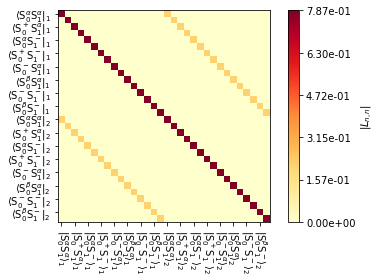

In [8]:
_=U0.plot(mode='abs')

### Special propagators

The Liouvillian can also produce propagators for $\delta$-pulses (i.e. pulses with zero length) and an identity propagator. Both types have zero length, and they can be multiplied with propagators ending at any time (they do acquire an initial time, but this is not checked when multiplying these types of propagators). The identity propagator does not have any effect on other propagators or density matrices, but is occasionally useful as a kind of propagator pre-allocation.

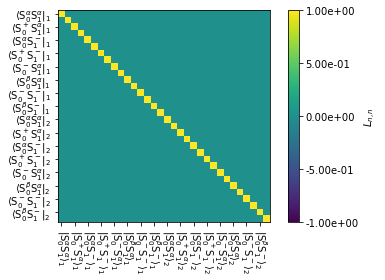

In [9]:
Ueye=L.Ueye()
_=Ueye.plot(mode='re')

A $\delta$-pulse propagator needs to be provided with a channel ('13C','1H', etc.) or a spin-index (0,1,2). The spin-index will apply the pulse just to one spin, even if there are other spins of the same nucleus type. While this is unphysical, it can be useful for creating selective pulses without requiring a full simulation of a complex pulse shape.

The default flip angle for the $\delta$-pulse is a $\pi$-pulse with an 'x' phase, but by adjusting phi (flip angle) and phase, any $\delta$-pulse may be obtained.

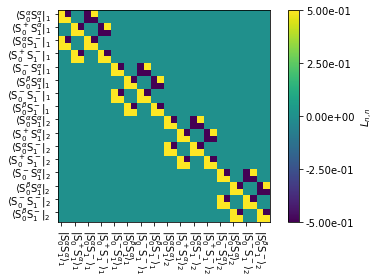

In [10]:
Ud=L.Udelta('13C',phi=np.pi/2,phase=np.pi/2)  #pi/2 y-pulse on 13C
_=Ud.plot(mode='re')

## Sequences

Of course, we would also like to be able to apply pulses within propagators. This is achieved with the sequence object, which is also generated from the Liouvillian. 

Sequences can be used to create propagators, although in some cases, propagators are only calculated internally within rho (next chapter) when used with a sequence.

We initialize a sequence by calling `L.Sequence()`. Usually, when we add channels to the sequence, we define a time-axis while doing so, which will then define the length of the sequence. However, it is possible to use the sequence to just define the amplitude (and optionally phase) of a continuously applied field (or even just a delay). In this case, under spinning, the sequence length then becomes one rotor period by default. If no spinning is used, then this case requires initializing the sequency with a length (`Dt=1e-3` would, for example, make a 1 ms sequence).

Once a sequence is defined, we add channels to it. Channels may be added the usual way, by specifying the nucleus, but they may also be added to a specific spin by index.

In [11]:
seq=L.Sequence()

We start with a sequence that has no time axis, just a constant field applied to $^{13}$C, applied in the *y*-direction. We use `seq.plot()` to visualize the result.

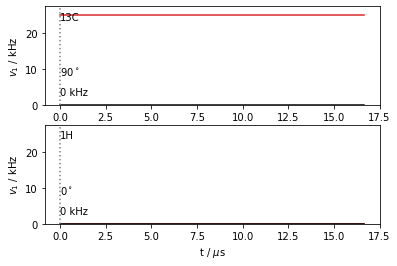

In [12]:
seq.add_channel('13C',v1=25000,phase=np.pi/2)
_=seq.plot()

Alternatively, we may use pulses. We may overwrite the existing channels, or just create a new sequence. Here we overwrite the $^{13}$C channel by calling it without any arguments (the default for v1 is 0). Note that the `seq.add_channel(...)` function returns the sequence, so we can string together multiple calls to `seq`.

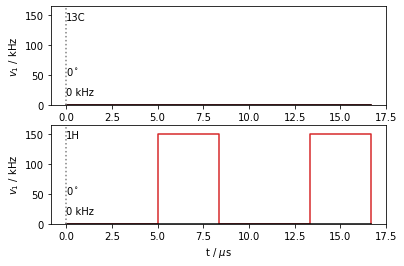

In [13]:
v1=150000
tpi=1/v1/2
t=[0,L.taur/2-tpi,L.taur/2,L.taur-tpi,L.taur]
_=seq.add_channel('13C').add_channel('1H',t=t,v1=[0,v1,0,v1]).plot()

This setup lets us easily create shaped pulses by just providing a time axis and a time-dependent amplitude. Note that for complex shapes, it is computationally advantageous to synchronize the time axis for the sequence with `n_gamma` for the rotor period, i.e. if `n_gamma` is 100, and we define a sequence over one rotor period, we would take 100 uniform time steps (i.e. `t=np.linspace(0,L.taur,ex.n_gamma)`).

### Generating propagators from sequences
A propagator is generated from a sequence by calling `seq.U()`. By default, the resulting propagator will have `t0` at `ex.current_time`, and `Dt` will be the length of the sequence (`seq.Dt`). However, both `t0` and `Dt` may be user defined when calling `seq.U`. Additionally, `t0_seq` may also be defined. This results in a propagator that starts partway through the sequence. Note that for a cyclic sequence (cyclic is the default sequence type, and can be changed by calling `L.Sequence(cyclic=False)`), `t0_seq` defaults to the end of the last call to the sequence, but defaults to 0 for `cyclic=False`. Then, we can interupt a sequence, for example, for detection, without having to actively re-synchronize it. 

We can observe this behavior below. We start with a 5 μs sequence, such that no $^1$H pulses are applied (the first pulse above starts at 5 μs). We obtain a propagator without off-diagonal terms in the imaginary part except due to exchange, since the system only has a heteronuclear dipole coupling.

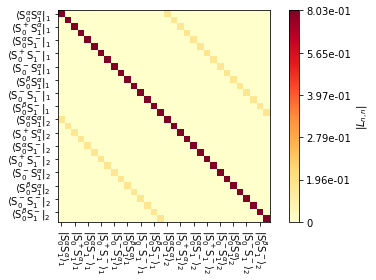

In [14]:
U0=seq.U(Dt=5e-6)
_=U0.plot()

Now, if we generate another 5 μs sequence, we obtain a very different propagator, because both `t0` and `t0_seq` have been set forward by 5 μs. Now the propagator contains a $\pi$-pulse on $^1$H. We can check `t0_seq` before and after generating `U1` to see how this works.

Before: 5.00 microseconds
After: 10.00 microseconds


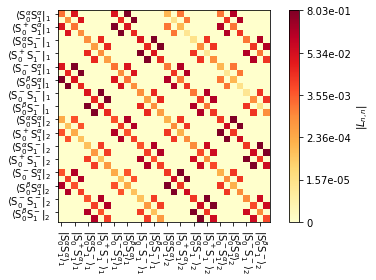

In [15]:
print(f'Before: {seq.t0_seq*1e6:.2f} microseconds')
U1=seq.U(Dt=5e-6)
print(f'After: {seq.t0_seq*1e6:.2f} microseconds')
_=U1.plot()

We complete the sequence, and do one more check of `t0_seq`, which should now be set back to 0. We also check that multiplying all the propagators together works, since they were generated one after another to cover a rotor cycle.

In [16]:
U2=seq.U(Dt=seq.Dt-U0.Dt-U1.Dt)
print(seq.t0_seq)

0.0


In [17]:
U2*U1*U0

Propagator with length of 16.667 microseconds (t0=0.000,tf=16.667)
Constructed from the following Liouvillian:
	Liouvillian under the following conditions:
		2-spin system (1H,13C)
		B0 = 14.092 T (600.000 MHz 1H frequency)
		rotor angle = 54.736 degrees
		rotor frequency = 60.0 kHz
		Temperature = 298 K
		Powder Average: JCP59 with 99 angles
	
	The individual Hamiltonians have the following interactions
		Hamiltonian #0
			dipole between spins 0,1 with arguments:
				(delta=44000.00)
			CSA on spin 1 with arguments: (delta=100.00,eta=1.00)
			CS on spin 0 with arguments: (ppm=10.00)
		
		Hamiltonian #1
			CSA on spin 1 with arguments: (delta=100.00,eta=1.00)
			CS on spin 0 with arguments: (ppm=10.00)
			dipole between spins 0,1 with arguments:
				(delta=44000.00,euler=[0.00,30.00,0.00])
		
		
	Hamiltonians are coupled by exchange matrix:
		array([[-50000.,  50000.],
		       [ 50000., -50000.]])
	

We will later see that sequences can be a powerful tool for performing more complicated calculations. For example, if we want to calculate spinning sidebands, we need to interrupt the rotor period to detect (detecting once a rotor period folds all sidebands back onto the main peak). However, we would have to then generate propagators for different parts of the rotor period and multiply them many times, always in the right order. While not impossible to code, it is somewhat tedious, and the calculations are somewhat slow. On the other hand, the `rho.DetProp` function, which will be introduced in the next section, may be combined with a sequence (possibly an empty one), to perform this operation in the eigenbases of the propagators to rapidly obtain a spectrum. This power comes from the flexibility of sequences, as compared to propagators, which are only valid starting at the same point in the rotor period.